# Step 2: 2D WTMM and automated terminus picking

_Last modified 2022-07-01._

This script analyzes image subsets over the glaciers using the adapted 2D Wavelet Transform Modulus Maxima (WTMM) segmentation method, producing terminus delineations.

The code is streamlined to analyze images for hundreds of glaciers, specifically, the marine-terminating glaciers along the periphery of Greenland. For use on other glaciers, sections of code must be modified:

    ##########################################################################################
    
    code to modify

    ##########################################################################################

In [1]:
import numpy as np
import pyfftw
from PIL import Image, ImageDraw
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import os
import json
import geojson
import pandas as pd
import time
from multiprocessing import Pool
import datetime
from pyproj import Proj

from Xsmurf_functions import *

/Users/jukesliu/micromamba/envs/autoterm/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
######################################################################################
basepath = '/Volumes/SGlacier/auto-terminus-traces/Antarctic-test/LSaws/' # contains glacier BoxID folders with downloaded images
csvpath = '/Volumes/SGlacier/auto-terminus-traces/Antarctic-test/' # path to where CSV files are saved
rotated_foldername = 'rotated_c2/' # name of subfolder containing preprocessed images for each glacier
PSproj = Proj(init='EPSG:3031') # desired projection for output delineations

# set glacier IDs here
# BoxIDs = ['001', '002', '003', '004', '005', '006', '007', '008', '009', \
#           '010', '011', '012', '013', '014', '015', '016', '017', '018', \
#           '019', '020', '021', '022', '023', '024', '025', '026', '027', \
#           '028', '029', '030', '031', '032', '033', '034', '035', '036', \
#           '037', '038', '039', '040', '041', '042', '043', '044', '045', \
#           '046', '047', '048', '049', '050']
BoxIDs = list(pd.read_csv(csvpath+'Buffdist_Antarctic-test.csv',dtype=str).BoxID) # read from a CSV file
print(BoxIDs)

# Default values are shown for the following parameters:
# Wavelet parameters (dictates number of spatial scales analyzed):
amin = 1
nOct = 5
nVox = 10
wavelet = 'gauss'

# Terminus pick parameters:
size_thresh = 0.4 # minimum size percentile across all images (0.4 recommended)
mod_thresh = 0.7 # minimum linemeanmod percentile across all images (0.7 recommended)
arg_thresh = 0.1 # minimum left-right argument fraction (0.1 recommended)
metric = 0 # 0 = mass, 1 = scaledmass, 2 = size, DEFAULT = 1
######################################################################################

/Users/jukesliu/micromamba/envs/autoterm/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


['Drummond', 'Funk']


In [21]:
BoxIDs = BoxIDs[1:]
BoxIDs

['Funk']

# How would you like to run the analysis?

    1) All images in a loop (slow)
    2) In batches (fast)
    3) Just one image (slowest, for development purposes only)

# Option 1) Process all images in series (loop)

Box raster dimensions: (743, 495)


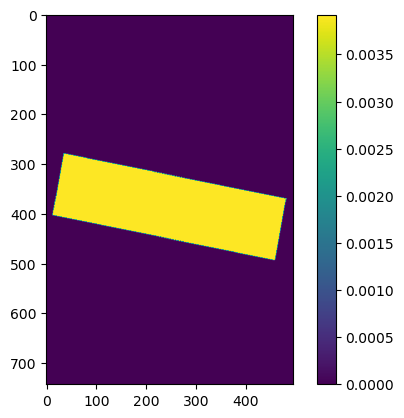

1 out of 75 R_LC09_L1GT_219106_20211122_20230505_02_T2_B8_BufferFunk.pgm
Scale: 6.976744186046512
Scale: 7.477489273509022
Scale: 8.014174569746757
Scale: 8.589379627987789
Scale: 9.205869144927169
Scale: 9.866606249114618
Scale: 10.5747667430958
Scale: 11.333754367761426
Scale: 12.147217162271499
Scale: 13.01906499818801
Scale: 13.953488372093023
Scale: 14.954978547018044
Scale: 16.02834913949351
Scale: 17.178759255975578
Scale: 18.411738289854338
Scale: 19.733212498229236
Scale: 21.149533486191604


/Users/jukesliu/Documents/GitHub/automated-glacier-terminus/Xsmurf_functions.py:851: RuntimeWarning: invalid value encountered in divide
  dx_norm = np.divide(dx,m)
/Users/jukesliu/Documents/GitHub/automated-glacier-terminus/Xsmurf_functions.py:852: RuntimeWarning: invalid value encountered in divide
  dy_norm = np.divide(dy,m)


Scale: 22.66750873552285
Scale: 24.294434324542998
Scale: 26.03812999637602
Scale: 27.906976744186046


In [ ]:
# Process all the images for the glaciers specified and show top 5 terminus chains
for BoxID in BoxIDs:
    t0 = time.time()
    processed_image_path = basepath+'Box'+BoxID+'/'+rotated_foldername
    imagelist = []
    for file in os.listdir(processed_image_path):
        if file.endswith('.pgm') and 'cut' not in file: #and 'L1TP' in file: # grab the L1TP corrected images only
            imagelist.append(file)
        elif file.endswith('cut.pgm'):
            boxfile = file
        
    # Load terminus box
    box = Image.open(processed_image_path+boxfile)
    box_array = np.array(box)
    if len(box_array.shape) == 3: # 3D array
        box_array = box_array[:,:,0]/255 # grab 1D slice from array and convert to binary
    elif len(box_array.shape) == 2: # 2D array
        box_array = box_array # already in binary
    print('Box raster dimensions:', box_array.shape)
    plt.imshow(box_array); plt.colorbar(); plt.show()  # Display mask

    # read in image Greenland Polar Stereographic coordinates
    PSy = np.array(pd.read_csv(basepath+'Box'+BoxID+'/'+rotated_foldername+'img_yidx_Box'+BoxID+'.csv',
                              delimiter=' ',header=None))
    # read in Greenland Polar Stereographic coordinates
    PSx = np.array(pd.read_csv(basepath+'Box'+BoxID+'/'+rotated_foldername+'img_xidx_Box'+BoxID+'.csv',
                              delimiter=' ',header=None))
    
    # hold all top chains produced from terminus picking
    topchains_alldfs = []
    
    image_num = 1
    # process all the images
    for image in imagelist:
        img = Image.open(processed_image_path+image)
        print(str(image_num)+' out of '+str(len(imagelist))+' '+image)
        
        # WTMM
        counter = 0
        all_cmm = [] # to hold all the chains produced
        # ascend over all scales
        # if True:
        for iOct in np.arange(0, nOct):
            for iVox in np.arange(0, nVox):

                # calculate scale in pixels
                scale = 6/0.86*amin*2**(iOct+(iVox/nVox))
                print('Scale: '+str(scale))

                # wavelet transform
                [dx, dy, mm, m, a] = wtmm2d_v2(img, wavelet, scale)
                
                # emask
                masked_a = emask(box_array, a)
                masked_mm = emask(box_array, mm)
                masked_m = emask(box_array, m)

                # chain
                cmm = wtmmchains(masked_mm,masked_a,0,scale,counter)

                # increment
                all_cmm.extend(cmm)
                counter = counter +1 
       
    
        # Make directory to store chain jsons:
        imgfolder = processed_image_path+image[:-4]+'_chains/'
        if not os.path.exists(imgfolder):
            os.mkdir(imgfolder)

        # Pick the terminus line
        # Find maximum mods and sizes for thresholding
        mods = []; sizes = []
        for chain in all_cmm:
            sizes.append(chain.size)
            mods.append(chain.linemeanmod)
        maxmod = np.nanmax(mods); maxsize = np.nanmax(sizes)
            
        mass_or_size = []
        passed_chains = []
        passcount = 0
        for chain in all_cmm:
            if chain.linemeanmod > mod_thresh*maxmod: # only chains that pass the mod threshold
#                 if chain.size > size_thresh*maxsize: # only chains that pass the size threshold
                if chain.size > size_thresh*np.sqrt(len(box_array[box_array > 0])):
                    [passedargs, argfrac] = filter_args(chain.args, np.pi/3) # identify the left & right-pointing args
                    if argfrac > arg_thresh: # only chains that pass the orientation threshold
                        if metric == 0:
                            mass_or_size.append(chain.mass)
                        elif metric == 1:
                            mass_or_size.append(chain.scaledmass)
                        else:
                            mass_or_size.append(chain.size)
                        passcount += 1
                        passed_chains.append(chain)
        
        if passcount > 0: # if chains remain:
            # sort by mass or size and grab the top 5
            zipped = zip(mass_or_size, passed_chains)              
            top_chains = sorted(zipped,reverse=True,
                                key=lambda zipped: zipped[0])[:5] # sort chains that passed

            # grab info from top 5 chains
            scales = []; boxids = []; orders = []; scenes = []; dates = []
            # write the top 5 to json
            for chain in top_chains:
                # grab the chain
                chain = chain[1]

                # convert dtypes to json serializable dtypes:
                chain.size = int(chain.size)
                chain.linemeanmod = float(chain.linemeanmod)
                chain.mass = float(chain.mass)
                chain.scaledmass = float(chain.scaledmass)
                chain.args = list(map(float, chain.args))
                chain.ix = list(map(int, chain.ix))
                chain.iy = list(map(int, chain.iy))
                chain.scale = str(chain.scale)
                scales.append(chain.scale.zfill(3))
                
                # grab geographic coordinates
                PSys = PSy[chain.iy, chain.ix]; PSxs = PSx[chain.iy,chain.ix]
                lons, lats = PSproj(PSxs, PSys, inverse=True) # project to WGS84
                polyline = geojson.LineString(list(zip(lons, lats))) # create polyline
                features = []
                date = datetime.datetime.strptime(image[19:27], '%Y%m%d'); date = date.strftime("%Y-%m-%d")
                features.append(geojson.Feature(geometry=polyline,
                                                properties={'datetime':date}))
                feature_collection = geojson.FeatureCollection(features)

                # write chain object to json file
                with open(imgfolder+chain.scale.zfill(3)+'_chain.json', 'w') as f:
                    json.dump(chain.__dict__, f)
                # write georeferenced chain to geojson file
                with open(imgfolder+chain.scale.zfill(3)+'_chain.geojson', 'w') as f:
                    geojson.dump(feature_collection, f)

            topchains_df = pd.DataFrame(top_chains,columns=['Metric','chain'])
            rows = len(topchains_df)

            for n in range(0,rows):
                boxids.append(BoxID.zfill(3)) # box string
                order = n+1 # order of chains (already sorted)
                orders.append(order)
                scenes.append(image[2:-20])
                date = datetime.datetime.strptime(image[19:27], '%Y%m%d')
                date = date.strftime("%Y-%m-%d"); dates.append(date)
            topchains_df['BoxID'] = boxids; topchains_df['Scene'] = scenes
            topchains_df['datetimes'] = dates;
            topchains_df['Scale'] = scales; topchains_df['Order'] = orders
            topchains_df = topchains_df[['BoxID','Scene','datetimes','Scale','Metric','Order']]
            topchains_alldfs.append(topchains_df)

            # visualize top chains:
            colors = pl.cm.viridis(np.linspace(0,1,5)) # generate colors using a colormap
            plt.figure(figsize=(8,8))
            plt.imshow(np.array(img), aspect='equal', cmap = 'gray')
            plt.gca().set_aspect('equal'); plt.gca().invert_yaxis()
            for k in range(0, len(top_chains)): # plot chains (purple = top, yellow = 5th)
                plt.plot(top_chains[len(top_chains)-1-k][1].ix, 
                         top_chains[len(top_chains)-1-k][1].iy, 's-', color=colors[k],markersize=0.1)
            plt.title(date, fontsize=16)
            plt.xticks([]); plt.yticks([])
            # make directory to save results to:
            resultsfolder = processed_image_path+'results/'
            if not os.path.exists(resultsfolder):
                os.mkdir(resultsfolder)
            plt.savefig(resultsfolder+date+'_'+image[:-4]+'_topchains.png',dpi=200)
            plt.show()
            

        image_num = image_num +1

    print(str(time.time() - t0)+' sec to process '+str(len(imagelist))+' images.')
    # write terminus pick file
    today = datetime.datetime.now().strftime("%Y_%m_%d")  # today's date string
    terminuspick_df = pd.concat(topchains_alldfs) # concatenate all the top pick data together
    terminuspick_df.to_csv(csvpath+'terminuspicks_Box'+BoxID.zfill(3)+'_'+today+'.csv') # write to csv

In [ ]:
[dx, dy, mm, m, a] = wtmm2d_v2(img, wavelet, scale)

# Option 2) Parallel process images in batches

Run wtmm2d_img() in batches:

In [3]:
# check number of cpus on machine using os:
print(os.cpu_count())

################################################################################################
# set batch size accordingly
# recommendation is to leave one or two cpus available for other background processing
batch_size = 10
print('Batch size:',batch_size)
################################################################################################

12
Batch size: 10


In [8]:
def wtmm2d_img(image):
    topchains_dfs = []       
    img = Image.open(processed_image_path+image)
    print(image)
       
    # Make directory to store chain jsons:
    imgfolder = processed_image_path+image+'_chains/'
    if not os.path.exists(imgfolder):
        os.mkdir(imgfolder)
        
    # WTMM
    counter = 0
    all_cmm = [] # to hold all the chains produced
    # ascend over all scales
    for iOct in np.arange(0, nOct):
        for iVox in np.arange(0, nVox):

            # calculate scale in pixels
            scale = 6/0.86*amin*2**(iOct+(iVox/nVox))

            # wavelet transform
            [dx, dy, mm, m, a] = wtmm2d_v2(img, wavelet, scale)

            # emask
            masked_a = emask(box_array, a)
            masked_mm = emask(box_array, mm)
            masked_m = emask(box_array, m)

            # chain
            cmm = wtmmchains(masked_mm,masked_a,0,scale,counter)

            # increment
            all_cmm.extend(cmm)
            counter = counter +1 

    # Pick the terminus line
    # Find maximum mods and sizes for thresholding
    mods = []; sizes = []
    for chain in all_cmm:
        sizes.append(chain.size)
        mods.append(chain.linemeanmod)
    maxmod = np.nanmax(mods); maxsize = np.nanmax(sizes)

    mass_or_size = []; passed_chains = []; passcount = 0
    for chain in all_cmm:
        if chain.linemeanmod > mod_thresh*maxmod: # only chains that pass the mod threshold
#                 if chain.size > size_thresh*maxsize: # only chains that pass the size threshold
            if chain.size > size_thresh*np.sqrt(len(box_array[box_array > 0])):
                [passedargs, argfrac] = filter_args(chain.args, np.pi/3) # identify the left & right-pointing args
                if argfrac > arg_thresh: # only chains that pass the orientation threshold
                    if metric == 0:
                        mass_or_size.append(chain.mass)
                    elif metric == 1:
                        mass_or_size.append(chain.scaledmass)
                    else:
                        mass_or_size.append(chain.size)
                    passcount += 1
                    passed_chains.append(chain)

    if passcount > 0: # if chains remain:
        # sort by mass or size and grab the top 5
        zipped = zip(mass_or_size, passed_chains)              
        top_chains = sorted(zipped,reverse=True,
                            key=lambda zipped: zipped[0])[:5] # sort chains that passed

        # grab info from top 5 chains
        scales = []; boxids = []; orders = []; scenes = []; dates = []
        # write the top 5 to json
        for chain in top_chains:
            # grab the chain
            chain = chain[1]

            # convert dtypes to json serializable dtypes:
            chain.size = int(chain.size)
            chain.linemeanmod = float(chain.linemeanmod)
            chain.mass = float(chain.mass)
            chain.scaledmass = float(chain.scaledmass)
            chain.args = list(map(float, chain.args))
            chain.ix = list(map(int, chain.ix))
            chain.iy = list(map(int, chain.iy))
            chain.scale = str(chain.scale)
            scales.append(chain.scale.zfill(3))

            # grab geographic coordinates
            PSys = PSy[chain.iy, chain.ix]; PSxs = PSx[chain.iy,chain.ix]
            lons, lats = PSproj(PSxs, PSys, inverse=True) # project to WGS84
            polyline = geojson.LineString(list(zip(lons, lats))) # create polyline
            features = []
            date = datetime.datetime.strptime(image[19:27], '%Y%m%d'); date = date.strftime("%Y-%m-%d")
            features.append(geojson.Feature(geometry=polyline,
                                            properties={'datetime':date}))
            feature_collection = geojson.FeatureCollection(features)

            # write chain object to json file
            with open(imgfolder+chain.scale.zfill(3)+'_chain.json', 'w') as f:
                json.dump(chain.__dict__, f)
            # write georeferenced chain to geojson file
            with open(imgfolder+chain.scale.zfill(3)+'_chain.geojson', 'w') as f:
                geojson.dump(feature_collection, f)

        topchains_df = pd.DataFrame(top_chains,columns=['Metric','chain'])
        rows = len(topchains_df)

        for n in range(0,rows):
            boxids.append(BoxID.zfill(3)) # box string
            order = n+1 # order of chains (already sorted)
            orders.append(order)
            scenes.append(image[2:-20])
            date = datetime.datetime.strptime(image[19:27], '%Y%m%d')
            date = date.strftime("%Y-%m-%d"); dates.append(date)
        topchains_df['BoxID'] = boxids; topchains_df['Scene'] = scenes
        topchains_df['datetimes'] = dates;
        topchains_df['Scale'] = scales; topchains_df['Order'] = orders
        topchains_df = topchains_df[['BoxID','Scene','datetimes','Scale','Metric','Order']]
        topchains_dfs.append(topchains_df)

        # visualize top chains:
        colors = pl.cm.viridis(np.linspace(0,1,5)) # generate colors using a colormap
        plt.figure(figsize=(8,8))
        plt.imshow(np.array(img), aspect='equal', cmap = 'gray')
        plt.gca().set_aspect('equal'); plt.gca().invert_yaxis()
        for k in range(0, len(top_chains)): # plot chains (purple = top, yellow = 5th)
            plt.plot(top_chains[len(top_chains)-1-k][1].ix, 
                     top_chains[len(top_chains)-1-k][1].iy, 's-', color=colors[k],markersize=0.1)
        plt.title(date, fontsize=16)
        plt.xticks([]); plt.yticks([])
        # make directory to save results to:
        resultsfolder = processed_image_path+'results/'
        if not os.path.exists(resultsfolder):
            os.mkdir(resultsfolder)
        plt.savefig(resultsfolder+image[:-4]+'_topchains.png',dpi=200)
        plt.show()

        return topchains_dfs
    else:
        print('No chains passed.')

Box 001 raster dimensions: (235, 221)


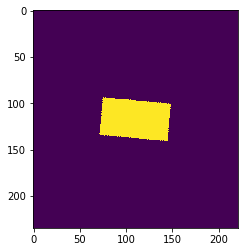

FileNotFoundError: [Errno 2] File /media/jukes/jukes1/LS8aws/Box001/rotated_c2/img_yidx_Box001.csv does not exist: '/media/jukes/jukes1/LS8aws/Box001/rotated_c2/img_yidx_Box001.csv'

In [9]:
for BoxID in BoxIDs:
    t1 = time.time()
    processed_image_path = basepath+'Box'+BoxID+'/'+rotated_foldername
    imagelist = []
    for file in os.listdir(processed_image_path):
        if file.endswith('PS.pgm') and 'L1TP' in file: # L1TP corrected images only
            imagelist.append(file)
        elif file.endswith('cut.pgm'):
            boxfile = file
        
    # Load terminus box
    box = Image.open(processed_image_path+boxfile)
    box_array = np.array(box)
    if len(box_array.shape) == 3: # 3D array
        box_array = box_array[:,:,0]/255 # grab 1D slice from array and convert to binary
    elif len(box_array.shape) == 2: # 2D array
        box_array = box_array # already in binary
    print('Box',BoxID,'raster dimensions:', box_array.shape)
    plt.imshow(box_array); plt.show()  # Display mask
    
    # read in image Greenland Polar Stereographic coordinates
    PSy = np.array(pd.read_csv(basepath+'Box'+BoxID+'/'+rotated_foldername+'img_yidx_Box'+BoxID+'.csv',
                              delimiter=' ',header=None))
    # read in image Greenland Polar Stereographic coordinates
    PSx = np.array(pd.read_csv(basepath+'Box'+BoxID+'/'+rotated_foldername+'img_xidx_Box'+BoxID+'.csv',
                              delimiter=' ',header=None))
    
    # hold all top chains produced from terminus picking
    topchains_alldfs = []
    
    # process all the images in parallel
    pcount = 0
    image_num = 1
    nbatches = int(np.ceil(len(imagelist)/batch_size)) # round up to the next batch size
    nfullbatches = int(np.floor(len(imagelist)/batch_size)) # number of full batches
    print(nbatches, 'batches')
    print(nfullbatches, 'full batches')
    
    # full batches
    for b in range(0, nfullbatches):
        pool = Pool() # initialize pool
        batchimgs = imagelist[b*batch_size:(b+1)*batch_size]
        topchains_dfs = pool.map(wtmm2d_img, batchimgs) # process all in pool
        topchains_alldfs += topchains_dfs
    
    # for the last batch
    if nbatches - nfullbatches == 1:
        pool = Pool()
        lastbatchimgs = imagelist[(b+1)*batch_size:] # grab all remaining images
        topchains_dfs = pool.map(wtmm2d_img, lastbatchimgs) # process all in pool
        topchains_alldfs += topchains_dfs

    dfs = []
    for df in topchains_alldfs:
        if df == None:
            topchains_alldfs.remove(df)
        else:
            dfs.append(df[0])
    
    print(str(time.time() - t1)+' sec to process '+str(len(imagelist))+' images.' )
    # write terminus pick file
    today = datetime.datetime.now().strftime("%Y_%m_%d")  # today's date string
    terminuspick_df = pd.concat(dfs) # concatenate all the top pick data together
    terminuspick_df = terminuspick_df.reset_index(drop=True) # reset the index
    terminuspick_df.to_csv(csvpath+'terminuspicks_Box'+BoxID.zfill(3)+'_'+today+'.csv') # write to csv

# Option 3) Process 1 image at a time

## 3A) Load terminus box

In [ ]:
######################################################################################
# use terminus box raster to mask out external chains
# box = Image.open(basepath+'R_Box174_raster_cut.png')
BOI = '012' # BoxID
box = Image.open(basepath+'Box'+BOI+'/'+rotated_foldername+'R_Box'+BOI+'_raster_cut.png')
######################################################################################
if len(box_array.shape) == 3: # 3D array
    box_array = box_array[:,:,0]/255 # grab 1D slice from array and convert to binary
elif len(box_array.shape) == 2: # 2D array
    box_array = box_array # already in binary
print(box_array.shape)
plt.imshow(box_array); plt.show()  # Display mask

## 3B) Open image(s) for testing:

In [ ]:
######################################################################################
# # open glacier image for testing
img = Image.open(basepath+'Box'+BOI+'/'+subfoldername+'R_LC08_L1TP_031005_20150716_20200908_02_T1_B8_Buffer012_PS.pgm')
# img = Image.open(basepath+'R_LC08_L1TP_233017_20170813_20170814_01_RT_B8_Buffer174_PS.pgm')
# OR generate circle image
# img = generate_circle_image(100, 436, 428) # inputs are radius, xsize, ysize
######################################################################################
img

## 3C) Run wtmm2d and show outputs:

In [ ]:
######################################################################################
# [dx,dy,F,f,gx,gy] = wtmm2d(img,'gauss',10)
[dx,dy,mm,m,a] = wtmm2d_v2(img,'gauss',25) # scale = 10 pixels
######################################################################################

In [ ]:
# Visualize outputs from wtmm2d:
fig, axs = plt.subplots(2,3,figsize=(15,10))
axs[0,0].imshow(dx, aspect='equal', cmap = 'gray', interpolation='none'); axs[0,0].set_title('dx') # x gradient
axs[0,1].imshow(dy, aspect='equal', cmap = 'gray', interpolation='none'); axs[0,1].set_title('dy') # y gradient

axs[0,2].imshow(a, aspect='equal', cmap = 'gray', interpolation='none'); axs[0,2].set_title('a') # argument            
axs[1,0].imshow(mm, aspect='equal', cmap = 'gray', interpolation='none', vmin = np.min(mm), vmax = np.max(m)); 
axs[1,0].set_title('mm') # modulus maxima (interpolated)
axs[1,1].imshow(m, aspect='equal', cmap = 'gray', interpolation='none',vmin = np.min(mm), vmax = np.max(m));
axs[1,1].set_title('m') # modulus
axs[-1, -1].axis('off')

# Image.fromarray(mm).save('mm.tif')   
# Image.fromarray(m).save('m.tif')   

# plt.savefig('glacier_WTMM_test.png',dpi=200)
plt.show()

## 3D) Mask using terminus box (emask)

In [ ]:
# Mask
masked_a = emask(box_array, a)
masked_mm = emask(box_array, mm)
masked_m = emask(box_array, m)

# Visualize masked outputs from wtmm2d:
fig, axs = plt.subplots(1,3,figsize=(15,10))

axs[0].imshow(masked_a, aspect='equal', cmap = 'viridis', interpolation='none'); axs[0].set_title('a')              
axs[1].imshow(masked_mm, aspect='equal', cmap = 'gray', interpolation='none', vmin = np.min(masked_mm), vmax = np.max(masked_mm)); 
axs[1].set_title('mm')
axs[2].imshow(masked_m, aspect='equal', cmap = 'gray', interpolation='none',vmin = np.min(masked_m), vmax = np.max(masked_m));
axs[2].set_title('m')
# plt.savefig('glacier_WTMM_test.png',dpi=200)
plt.show()

## 3E) Chain remaining mms

In [ ]:
######################################################################################
cmm = wtmmchains(masked_mm,masked_a,1,10,3) # chain at a specified scale
######################################################################################

In [ ]:
cmm_passed = []
# Filter chains based on size threshold
for j in range(0, len(cmm)):
    if cmm[j].size > 0: # adjust this condition to threshold
        cmm_passed.append(cmm[j])

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(masked_mm,cmap='gray')
plt.xlim([0, mm.shape[1]])
plt.ylim([0, mm.shape[0]])
plt.gca().set_aspect('equal'); plt.gca().invert_yaxis()
    
for k in range(0, len(cmm_passed)):
    plt.plot(cmm_passed[k].ix, cmm_passed[k].iy, 's-', markersize=0.5)
plt.show()

## 3F) Use thresholds on chain properties to pick the glacier terminus chain

In [ ]:
######################################################################################
size_thresh = 0.4 # Size percentile across all images
mod_thresh = 0.7 # Linemeanmod percentile across all images
arg_thresh = 0.1 # left-right argument fraction
metric = 0 # 0 = mass, 1 = scaledmass, 2 = size
######################################################################################

In [ ]:
# read in Greenland Polar Stereographic coordinates
PSy = np.array(pd.read_csv(basepath+'Box'+BOI+'/'+subfoldername+'img_idx_PSy_Box'+BOI+'.csv',
                          delimiter=' ',header=None))
# read in Greenland Polar Stereographic coordinates
PSx = np.array(pd.read_csv(basepath+'Box'+BOI+'/'+subfoldername+'img_idx_PSx_Box'+BOI+'.csv',
                          delimiter=' ',header=None))

In [ ]:
mass_or_size = []
passed_chains = []
for chain in cmm_passed:
    if chain.linemeanmod > mod_thresh: # only chains that pass the mod threshold
        if chain.size > size_thresh: # only chains that pass the size threshold
            [passedargs, argfrac] = filter_args(chain.args, np.pi/3) # identify the left & right-pointing args
            if argfrac > arg_thresh: # only chains that pass the orientation threshold
                if metric == 0:
                    mass_or_size.append(chain.mass) # evaluate by mass (length*gradient value)
                elif metric == 1:
                    mass_or_size.append(chain.scaled_mass) # evaluate by scaled mass (mass/2**scale)
                else:
                    mass_or_size.append(chain.size)
                PSxs = PSx[np.array(chain.ix,dtype=int)]
                PSys = PSy[np.array(chain.iy,dtype=int)]
                passed_chains.append(chain)

In [ ]:
top_chains = pd.DataFrame(list(zip(mass_or_size, passed_chains)), columns=['metric_val','chainobj'])
top_chains = top_chains.sort_values(by=['metric_val'],ascending=False) # sort chains with highest metric at top
top_chains = top_chains[:5].reset_index(drop=True) # and grab the top 5
top_chains 

In [ ]:
# visualize top chains:
colors = pl.cm.viridis(np.linspace(0,1,5)) # generate colors using a colormap
plt.figure(figsize=(8,8))
plt.imshow(np.array(img), aspect='equal', cmap = 'gray')
plt.gca().set_aspect('equal'); plt.gca().invert_yaxis()
for k in range(0, len(top_chains)):
    # plot chains, darker = better picks
    plt.plot(top_chains[k][1].ix, top_chains[k][1].iy, 's-', color=colors[k],markersize=0.1)
#     break
            
plt.show()

In [ ]:
top_chains[k][1].ix